# Classification with Naive Bayes

```{note}
This is typically not required but can fix issues.  Mine was caused because I installed a package that reverted the version of my jupyter.  This was the same problem that caused the notes to not render correctly.

The solution to this is to use environments more carefully.
```

In [1]:
%matplotlib inline

We'll start with the same dataset as Monday.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
iris_df = sns.load_dataset('iris')

In [3]:
# dataset vars:
# ,
feature_vars = ['petal_width', 'sepal_length', 'sepal_width','petal_length']
target_var = 'species'
X_train, X_test, y_train, y_test = train_test_split(iris_df[feature_vars],iris_df[target_var],random_state=0)

Using the `random_state` makes it so that we get the same "random" set each type we run the code. [see docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#:~:text=the%20test%20size.-,random_state,-int%2C%20RandomState%20instance)

In [4]:
X_train.head()

,petal_width,sepal_length,sepal_width,petal_length
61,1.5,5.9,3.0,4.2
92,1.2,5.8,2.6,4.0
112,2.1,6.8,3.0,5.5
2,0.2,4.7,3.2,1.3
141,2.3,6.9,3.1,5.1


In [5]:
iris_df.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa


In [6]:
X_train.shape, iris_df.shape

((112, 4), (150, 5))

In [7]:
112/150

0.7466666666666667

We can see that we get ~75% of the samples in the training set by default.  We could also see this from the docstring.


Again we will instantiate the object.

In [8]:
gnb = GaussianNB()

In [9]:
gnb.__dict__

{'priors': None, 'var_smoothing': 1e-09}

In [10]:
gnb.fit(X_train,y_train)

GaussianNB()

we fit the Gaussian Naive Bayes, it computes a mean
$\theta$ and variance $\sigma$ and adds them to model parameters in attributes
`gnb.theta_, gnb.sigma_`.

In [11]:
gnb.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'classes_': array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 'feature_names_in_': array(['petal_width', 'sepal_length', 'sepal_width', 'petal_length'],
       dtype=object),
 'n_features_in_': 4,
 'epsilon_': 3.2135586734693885e-09,
 'theta_': array([[0.24054054, 4.9972973 , 3.38918919, 1.45405405],
        [1.30882353, 5.91764706, 2.75882353, 4.19117647],
        [2.03902439, 6.66341463, 2.9902439 , 5.58292683]]),
 'var_': array([[0.01159971, 0.12242513, 0.14474799, 0.01978087],
        [0.0408045 , 0.2649827 , 0.11124568, 0.22139274],
        [0.06579417, 0.4071981 , 0.11453897, 0.30483046]]),
 'class_count_': array([37., 34., 41.]),
 'class_prior_': array([0.33035714, 0.30357143, 0.36607143])}

The attributes of the [estimator object](https://scikit-learn.org/stable/glossary.html#term-estimators) (`gbn`) describe the data (eg the class list) and the model's parameters. The `theta_` ($\theta$)
represents the mean and the `sigma_` ($\sigma$) represents the variance of the
distributions.  

```{admonition} Try it Yourself
Could you use what we learned about EDA to find the mean and variance of each
feature for each species of flower?
```


Because the GaussianNB classifier calculates parameters that describe the
assumed distribuiton of the data is is called a generative classifier.  From a
generative classifer, we can generate synthetic data that is from the
distribution the classifer learned. If this data looks like our real data, then
the model assumptions fit well.

```{warning}
the details of this math are not required understanding, but this describes the
following block of code

```
````{margin}
```{hint}
to try understanding this block of code, try extracting pieces of it and running
each piece individually. I built it up piece by piece adn then wrapped them all
together.
```
````
To do this, we extract the mean and variance parameters from the model
(`gnb.theta_,gnb.sigma_`) and `zip` them together to create an iterable object
that in each iteration returns one value from each list (`for th, sig in zip(gnb.theta_,gnb.sigma_)`).
We do this inside of a list comprehension and for each `th,sig` where `th` is
from `gnb.theta_` and `sig` is from `gnb.sigma_` we use `np.random.multivariate_normal`
to get 20 samples. In a general [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) the second parameter is actually a covariance
matrix.  This describes both the variance of each individual feature and the
correlation of the features.  Since Naive Bayes is Naive it assumes the features
are independent or have 0 correlation.  So, to create the matrix from the vector
of variances we multiply by `np.eye(4)` which is the identity matrix or a matrix
with 1 on the diagonal and 0 elsewhere. Finally we stack the groups for each
species together with `np.concatenate` (like `pd.concat` but works on numpy objects
  and `np.random.multivariate_normal` returns numpy arrays not data frames) and put all of that in a
DataFrame using the feature names as the columns.

Then we add a species column, by repeating each species 20 times
`[c]*N for c in gnb.classes_` and then unpack that into a single list instead of
as list of lists.

In [12]:
N = 20
gnb_df = pd.DataFrame(np.concatenate([np.random.multivariate_normal(th, sig*np.eye(4),N)
         for th, sig in zip(gnb.var_,gnb.sigma_)]),
         columns = feature_vars)
gnb_df['species'] = [ci for cl in [[c]*N for c in gnb.classes_] for ci in cl]

/opt/hostedtoolcache/Python/3.9.15/x64/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


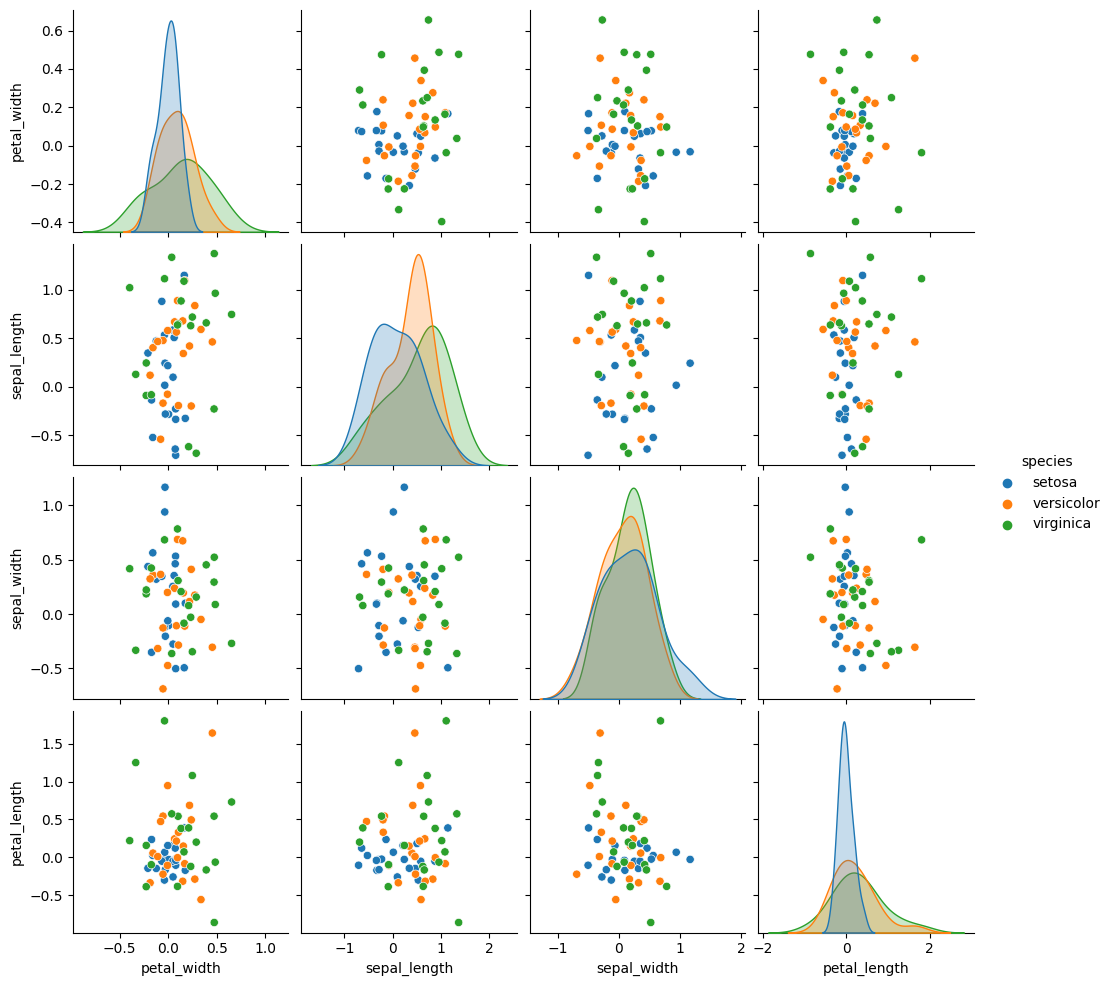

In [13]:
sns.pairplot(data =gnb_df, hue='species')

````{margin}
```{admonition} Further Reading
There are other classifiers that use roughly the same model but don't make the
naive assumption. The more flexible is called Quadratic Discriminant Analysis.
- [mathematical formulation](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda-math) for both
- [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) code
- [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) code
```
````

This one looks pretty close to the actual data.  The biggest difference is that
these data are all in uniformly circular-ish blobs and the ones above are not.  
That means that the naive assumption doesn't hold perfectly on this data.

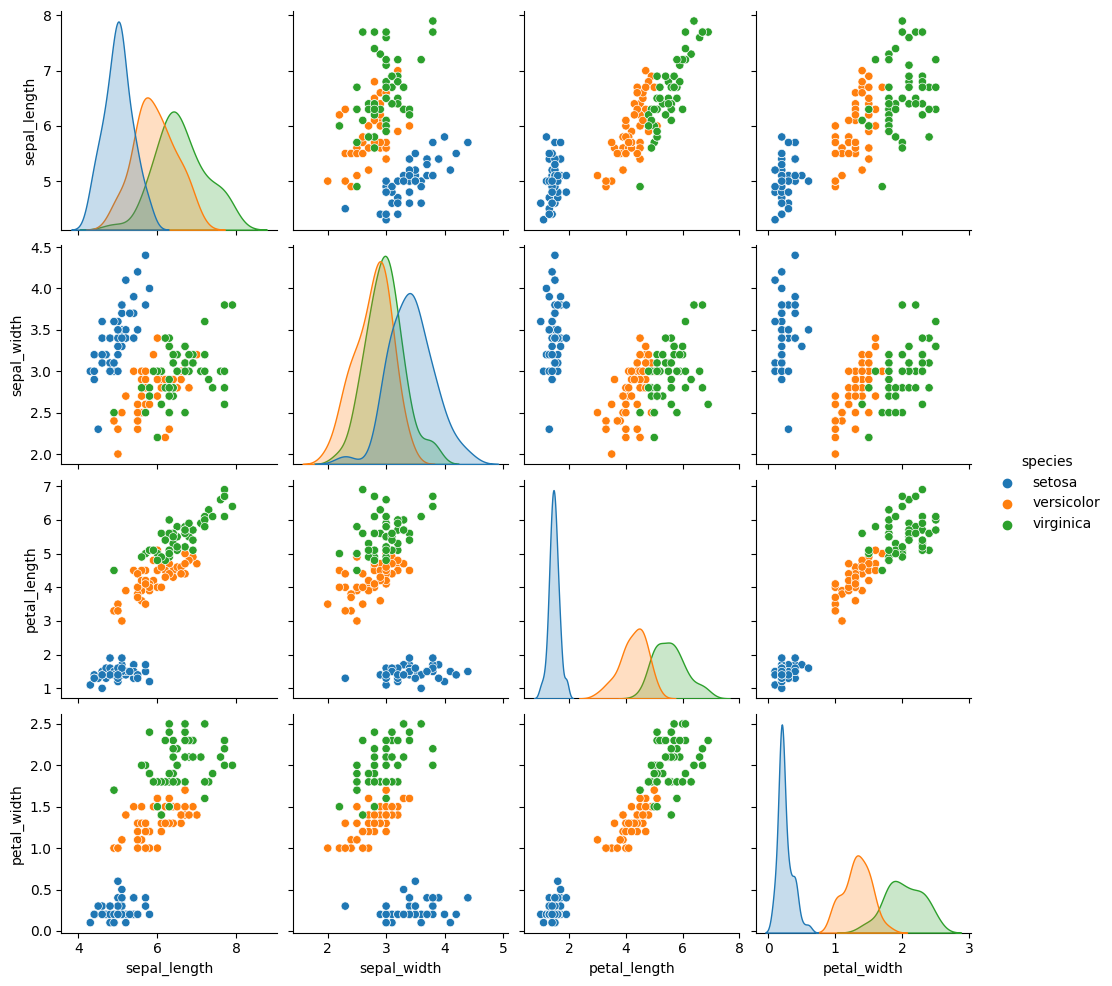

In [14]:
sns.pairplot(data=iris_df,hue='species')

When we use the predict method, it uses those parameters to calculate the
likelihood of the sample according to a Gaussian distribution (normal) for each class and then calculates the probability of the sample belonging to each class and returns the one with the highest probability.

In [15]:
y_pred = gnb.predict(X_test)

We can check the performance by comparing manually

In [16]:
sum(y_pred ==y_test)/len(y_test)

1.0

Or by scoring  it.

In [17]:
gnb.score(X_test,y_test)

1.0

In [18]:
metrics.confusion_matrix(y_test,y_pred)

array([[13,  0,  0],
       [ 0, 16,  0],
       [ 0,  0,  9]])

## Interpretting probabilities

In [19]:
gnb.predict_proba(X_test)

array([[2.05841140e-233, 1.23816844e-006, 9.99998762e-001],
       [1.76139943e-084, 9.99998414e-001, 1.58647449e-006],
       [1.00000000e+000, 1.48308613e-018, 1.73234612e-027],
       [6.96767669e-312, 5.33743814e-007, 9.99999466e-001],
       [1.00000000e+000, 9.33944060e-017, 1.22124682e-026],
       [4.94065646e-324, 6.57075840e-011, 1.00000000e+000],
       [1.00000000e+000, 1.05531886e-016, 1.55777574e-026],
       [2.45560284e-149, 7.80950359e-001, 2.19049641e-001],
       [4.01160627e-153, 9.10103555e-001, 8.98964447e-002],
       [1.46667004e-094, 9.99887821e-001, 1.12179234e-004],
       [5.29999917e-215, 4.59787449e-001, 5.40212551e-001],
       [4.93479766e-134, 9.46482991e-001, 5.35170089e-002],
       [5.23735688e-135, 9.98906155e-001, 1.09384481e-003],
       [4.97057521e-142, 9.50340361e-001, 4.96596389e-002],
       [9.11315109e-143, 9.87982897e-001, 1.20171030e-002],
       [1.00000000e+000, 7.81797826e-019, 1.29694954e-028],
       [3.86310964e-133, 9.87665084e-001

These are hard to interpret as is, one option is to plot them

In [20]:
# make the prbabilities into a dataframe labeled with classes & make the index a separate column
prob_df = pd.DataFrame(data = gnb.predict_proba(X_test), columns = gnb.classes_ ).reset_index()
# add the predictions
prob_df['predicted_species'] = y_pred
prob_df['true_species'] = y_test.values
# for plotting, make a column that combines the index & prediction
pred_text = lambda r: str( r['index']) + ',' + r['predicted_species']
prob_df['i,pred'] = prob_df.apply(pred_text,axis=1)
# same for ground truth
true_text = lambda r: str( r['index']) + ',' + r['true_species']
prob_df['correct'] = prob_df['predicted_species'] == prob_df['true_species']
# a dd a column for which are correct
prob_df['i,true'] = prob_df.apply(true_text,axis=1)
prob_df_melted = prob_df.melt(id_vars =[ 'index', 'predicted_species','true_species','i,pred','i,true','correct'],value_vars = gnb.classes_,
                             var_name = target_var, value_name = 'probability')
prob_df_melted.head()

,index,predicted_species,true_species,"i,pred","i,true",correct,species,probability
0,0,virginica,virginica,"0,virginica","0,virginica",True,setosa,2.058411e-233
1,1,versicolor,versicolor,"1,versicolor","1,versicolor",True,setosa,1.761399e-84
2,2,setosa,setosa,"2,setosa","2,setosa",True,setosa,1.000000e+00
3,3,virginica,virginica,"3,virginica","3,virginica",True,setosa,6.967677e-312
4,4,setosa,setosa,"4,setosa","4,setosa",True,setosa,1.000000e+00


Now we have a data frame where each rown is one the probability of one sample belonging to one class. So there's a total of `number_of_samples*number_of_classes` rows

In [21]:
prob_df_melted.shape

(114, 8)

In [22]:
len(y_pred)*len(gnb.classes_)

114

One way to look at these is to, for each sample in the test set, make a bar chart of the probability it belongs to each class.  We added to the data frame information so that we can plot this with the true class in the title using `col = 'i,true'`

````{margin}
```{tip}
I used `set_theme` to change both the fond size and the color palette.
Seaborn has a [detailed guide](https://seaborn.pydata.org/tutorial/color_palettes.html#palette-tutorial)
for choosing colors. The `colorblind` palette uses colors that are distinguishable under most common
forms of color blindness.
```
````

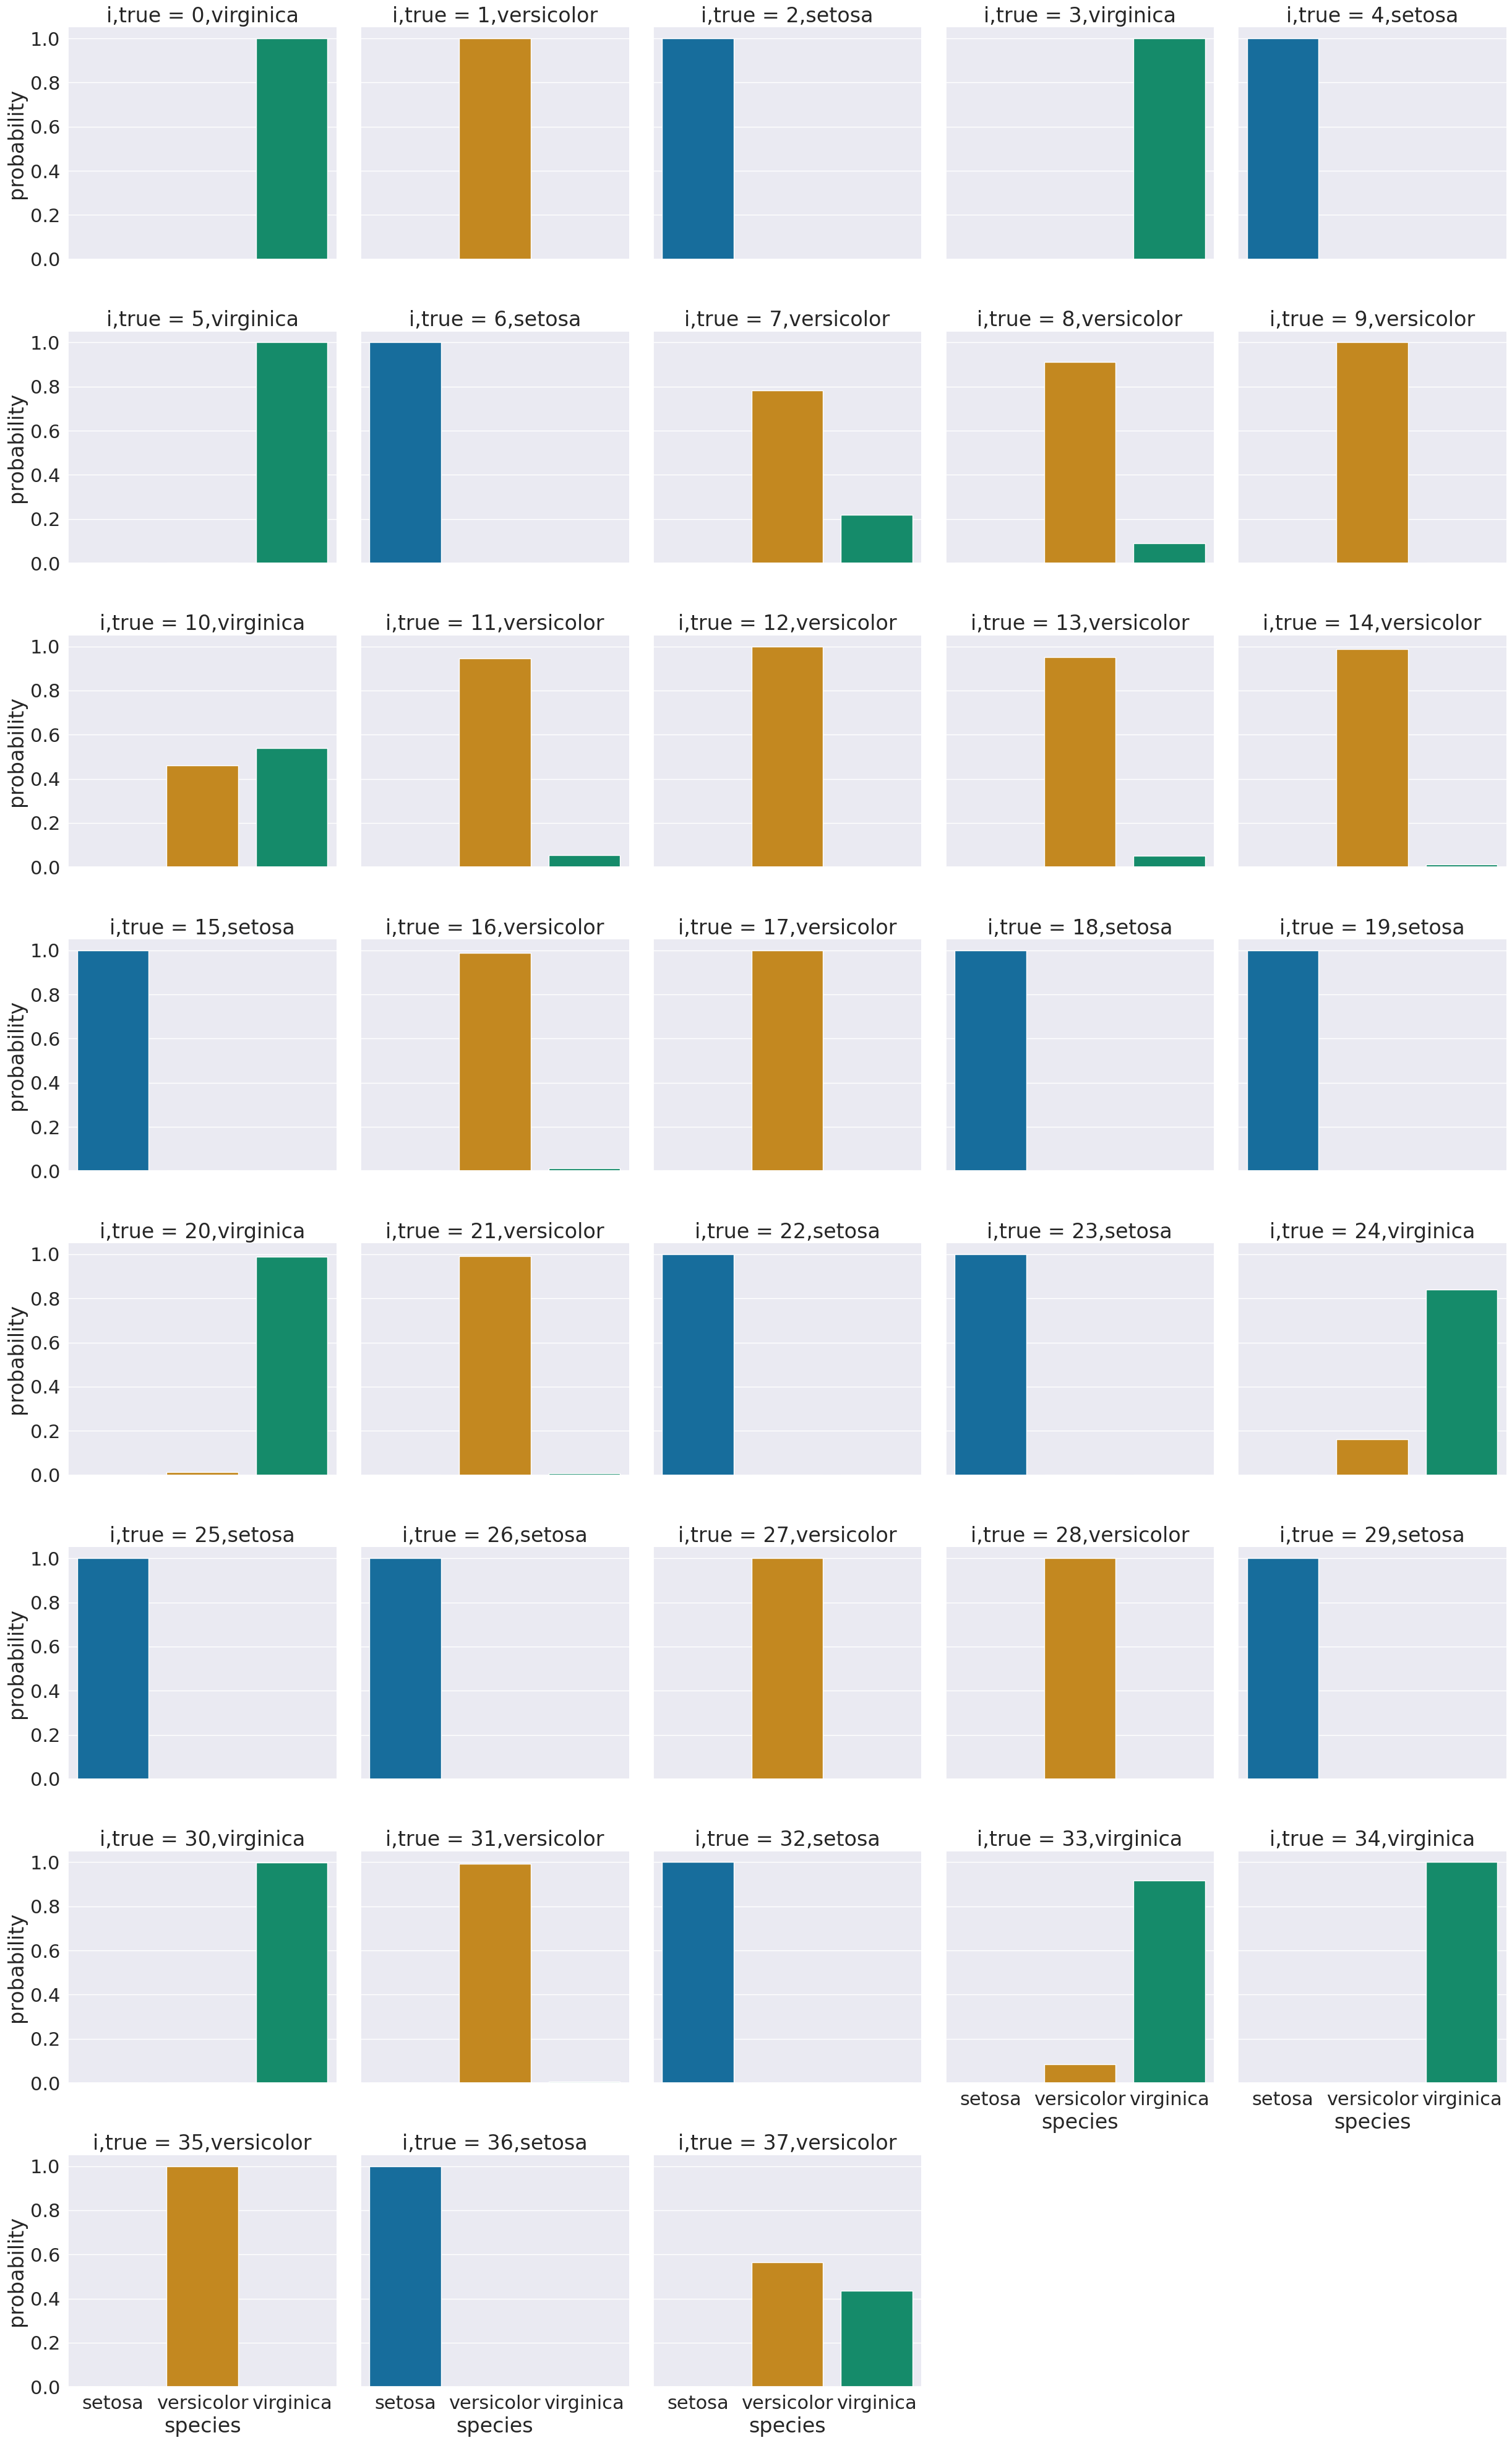

In [23]:
sns.set_theme(font_scale=2, palette= "colorblind")
# plot a bar graph for each point labeled with the prediction
sns.catplot(data =prob_df_melted, x = 'species', y='probability' ,col ='i,true',
            col_wrap=5,kind='bar')

We see that most sampples have nearly all of their probability mass (all probabiilties in a distribution sum (or integrate if continuous) to 1, but a few samples are not.

## Questions After Class

### What are the train and test datasets?

They are subsets of the original dataset.

For example if I use the index of the test set to pick a set of rows from the original dataset

In [24]:
iris_df.iloc[X_test.index[:5]]

,sepal_length,sepal_width,petal_length,petal_width,species
114,5.8,2.8,5.1,2.4,virginica
62,6.0,2.2,4.0,1.0,versicolor
33,5.5,4.2,1.4,0.2,setosa
107,7.3,2.9,6.3,1.8,virginica
7,5.0,3.4,1.5,0.2,setosa


and compare it to the actual test set

In [25]:
X_test.head()

,petal_width,sepal_length,sepal_width,petal_length
114,2.4,5.8,2.8,5.1
62,1.0,6.0,2.2,4.0
33,0.2,5.5,4.2,1.4
107,1.8,7.3,2.9,6.3
7,0.2,5.0,3.4,1.5


the columns are out of order because of how we created the train test splits, but the data are the same.  

We split the data so that we can be sure that the algorithm is generalizing what it learned from the test set.

### y_pred = gnb.predict(X_test). What is this predicting?

This uses the model to find the highest probability class for each sample in the test set.

### What is the best number of samples to use to have the most accurate predictions?

That will vary and is one of the things you will experiment with in assignment 7.

### need more clarification on the confusion_matrix. not sure what its doing if we already proved y_pred and y_test are the same

In this case, it does basically repeat that, except it does it per species (class).  Notice that all of the numbers are on the diagonal of the matrix.

### Can we use this machine learning to predict MIC data of peptides based off their sequences and similarly output data for new synthetic AMPS?

Possibly, but maybe a different model. I would need to know more about the dat here and I am not a biologist. We can discuss this in office hours.

### If more samples of data increases accuracy of the model, is there ever a point where adding more samples of data does not increase accuracy?

More samples increases the reliability of the estimate, and generally increases the accuracy, but not always. We will see different ways that more data does not increase over the next few weeks.  You will also experiment with this in your next assignment (I give you the steps, you interpret the results)